In [155]:
import imageio
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

In [156]:
def imageRead(imgname, pilmode='L', arrtype=np.float64):
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    imageio.imwrite(imgname, arrF.astype(arrtype))

## task 1

In [157]:
def downsample(arrF, mn=(1, 1)):
    m, n = mn
    arrG = arrF[::m, ::n]
    return arrG

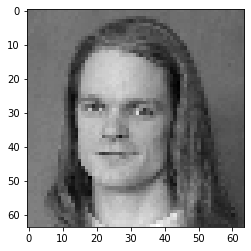

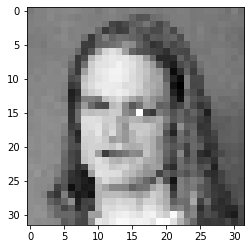

In [158]:
arrF = imageRead('Data/portrait.png')

for mn in [(4, 4), (8, 8)]:
    arrG = downsample(arrF, mn)
    plt.imshow(arrG, cmap='gray')
    plt.imsave(f'Figures/t1-{mn[0]}.png', arrG, cmap='gray')
    plt.show()

## task 2

In [159]:
def upsample(arrF, mn=(1, 1)):
    m, n = mn
    arrB = np.ones((m, n))
    arrG = np.kron(arrF, arrB)
    return arrG

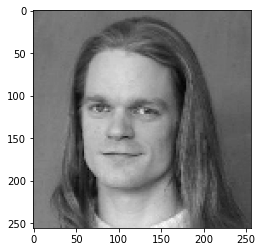

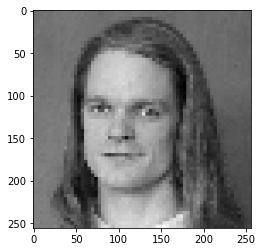

In [160]:
for mn in [(2, 2), (4, 4)]:
    arrG = upsample(downsample(arrF, mn), mn)
    plt.imshow(arrG, cmap='gray')
    plt.imsave(f'Figures/t2-{mn[0]}.png', arrG, cmap='gray')
    plt.show()

## task 3

In [161]:
def meanSuperPixelV1(arrF, m, n):
    M, N = arrF.shape
    arrG = np.zeros((M, N))
    for i in range(0, M, m):
        for j in range(0, N, n):
            intensity_sum = 0
            for k in range(m):
                for l in range(n):
                    intensity_sum += arrF[i+k,j+l]
            intensity_avg = intensity_sum / (m*n)
            arrG[i:i+m,j:j+n] = intensity_avg
    return arrG

def meanSuperPixelV2(arrF, m, n):
    M, N = arrF.shape
    arrG = np.zeros((M, N))
    for i in range(0, M, m):
        for j in range(0, N, n):
            arrG[i:i+m,j:j+n] = np.mean(arrF[i:i+m,j:j+n])
    return arrG

def meanSuperPixelV3(arrF, m, n):
    M, N = arrF.shape
    arrG = np.reshape(arrF, (M*N//n, n))
    arrG = np.mean(arrG, axis=1)
    arrG = np.reshape(arrG, (M,N//n))
    arrH = np.reshape(arrG, (m, (M//m)*(N//n)), 'F')
    arrH = np.mean(arrH, axis=0)
    arrH = np.reshape(arrH, (M//m, N//n), 'F')
    return np.kron(arrH, np.ones((m,n)))

def meanSuperPixelV4(arrF, m, n):
    M, N = arrF.shape
    arrA = np.add.reduceat(arrF, np.arange(0,N,n), axis=1) / n
    arrB = np.add.reduceat(arrA, np.arange(0,M,m), axis=0) / m
    arrC = np.repeat(arrB, n, axis=1)
    arrD = np.repeat(arrC, m, axis=0)  
    return arrD

In [162]:
import timeit, functools

nRep = 3
nRun = 100

for mtd in [meanSuperPixelV1, meanSuperPixelV2, meanSuperPixelV3, meanSuperPixelV4]:
    ts = timeit.Timer(functools.partial(mtd, arrF, 8, 8)).repeat(nRep, nRun)
    print(f'{mtd.__name__} took {min(ts) / nRun} s')

meanSuperPixelV1 took 0.026969980959984242 s
meanSuperPixelV2 took 0.024926821480039506 s
meanSuperPixelV3 took 0.0009693188600067515 s
meanSuperPixelV4 took 0.00032182032999116927 s


## task 4

In [163]:
def medianSuperPixelV2(arrF, m, n):
    M, N = arrF.shape
    arrG = np.zeros((M, N))
    for i in range(0, M, m):
        for j in range(0, N, n):
            arrG[i:i+m,j:j+n] = np.median(arrF[i:i+m,j:j+n])
    return arrG

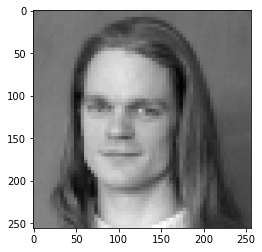

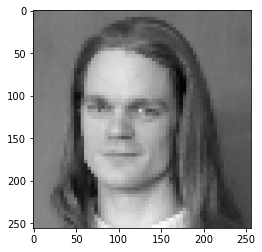

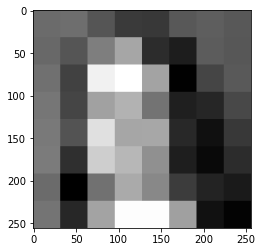

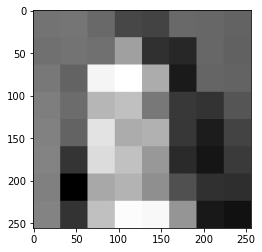

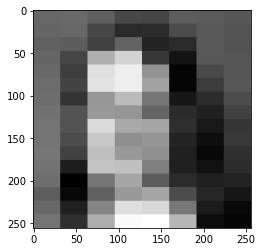

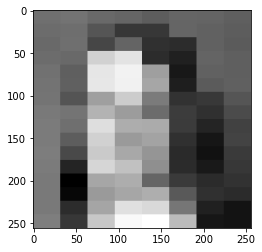

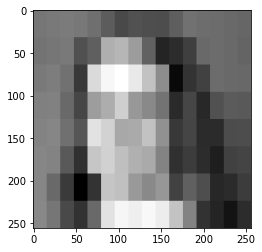

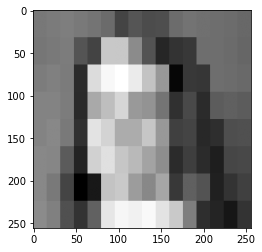

In [164]:
for m, n in [(4, 4), (32, 32), (16, 32), (32, 16)]:
    arrG = meanSuperPixelV2(arrF, m, n)
    plt.imshow(arrG, cmap='gray')
    plt.imsave(f'Figures/t4-mean({m}, {n}).png', arrG, cmap='gray')
    plt.show()
    
    arrG = medianSuperPixelV2(arrF, m, n)
    plt.imshow(arrG, cmap='gray')
    plt.imsave(f'Figures/t4-median({m}, {n}).png', arrG, cmap='gray')
    plt.show()
    
    

## task 5

In [165]:
arrF = imageRead('Data/bauckhage.jpg', pilmode='RGB')

In [166]:
m, n = 64, 64

arrG = np.empty_like(arrF)
for layer in range(3):
    arrG[:, :, layer] = medianSuperPixelV2(arrF[:, :, layer], m, n)

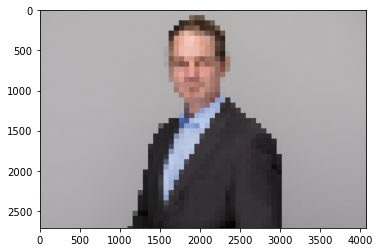

In [167]:
plt.imshow(arrG / 255)
plt.imsave('Figures/t5.png', arrG / 255)
plt.show()

## task 6

In [168]:
def random_tiling(arrF, tile_size=(13, 7), max_offset=10):
    m, n = arrF.shape
    arrG = np.zeros_like(arrF)
    # get indices of meshgrid
    indices = np.indices((m, n))
    # get random offsets in both x and y directions tilewise
    n_offsets = np.ceil(m / tile_size[0]).astype(int), \
                np.ceil(n / tile_size[1]).astype(int)
    offsets = np.random.randint(-max_offset, max_offset + 1,
                                (2, *n_offsets))
    # repeat each offset tile_size times
    offsets_tiled = np.kron(offsets, np.ones((1, *tile_size))).astype(int)[:, :m, :n]
    # add offsets
    indices += offsets_tiled
    # make sure indices are in bounds
    indices = np.clip(indices, 0, 255)
    # set input to the offset position in the output array
    arrG[indices[0], indices[1]] = arrF
    return arrG

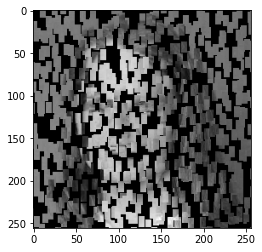

In [169]:
arrF = imageRead('Data/portrait.png')
arrG = random_tiling(arrF)
plt.imshow(arrG, cmap='gray')
plt.show()

## task 7

In [179]:
sigma = 5.
msize = int(np.ceil(sigma * 2.575) * 2 + 1)
xs = np.arange(msize)
vecG = np.exp(-0.5 * ((xs-msize/2) / sigma)**2).reshape(msize,1)
vecG /= np.sum(vecG)
print(vecG.shape)

(27, 1)


In [180]:
matG = np.outer(vecG, vecG)
matG /= np.sum(matG)
print(matG.shape)

(27, 27)


In [181]:
vecH = np.kron(vecG, vecG)
vecH /= np.sum(vecH)
print(vecH.shape)

(729, 1)


In [182]:
arrg = np.interp(vecG, (vecG.min(), vecG.max()), (0, 255))
arrG = np.interp(matG, (matG.min(), matG.max()), (0, 255))

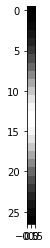

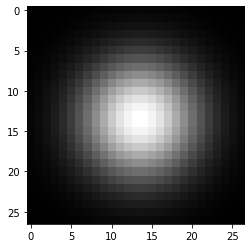

In [184]:
plt.imshow(arrg / 255, cmap='gray')
plt.show()
plt.imshow(arrG / 255, cmap='gray')
plt.show()